# When will the UK Population be Fully Vaccinated Against Covid-19?



Basics of Covid-19 vaccines:
- when first vaccine given
- 2 doses (space between)
- AstraZeneca and Pfizer
- priority groups


## Setup

In [1]:
# Get data from the internet
import requests
import json

# Analyse data and dates
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualisations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use("seaborn-notebook")
fontsize = 14
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rc('axes', labelsize=fontsize)
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
width = 12
height = 5
figsize = (width, height)
%matplotlib inline

## Getting the data

The government has developed a Coronavirus dashboard which is updated daily with key statistics including the number of Covid-19 tests, cases, hospitalisations, deaths and vaccinations. You can view the dashboard here: https://coronavirus.data.gov.uk/

All of the source data can be downloaded, for example as a spreadsheet, by clicking the "download" button under each table or graph. Even better for our purposes is that the dashboard has an "Application Programming Interface" (API), which we can use to extract precisely the data we're interested in programmatically from this notebook!

The documentation for the API is found under the ["Developer's Guide" section](https://coronavirus.data.gov.uk/details/developers-guide) of the dashboard, which describes the various parameters that are available and how they should be configured. In particular, there are Python examples which show us how to structure a data query. There are three main steps, as follows:

**Step 1:** Defining the geographical region we are interested in. Some of the data is available regionally as well as nationally. The number of positive cases, for example, is available both for the UK as a whole but also down to "local authority" level (local council areas, of which there are over 300 in England alone). However, the vaccination data we're interested in is only available as summary totals for the whole UK (although this is perfect for our purposes).

In the API, to define that we wish to retrieve summary data for the whole UK we must set the `areaType` parameter to be the value "overview", as follows:

In [2]:
filters = "areaType=overview"

If for a different analysis we wanted data for a smaller area we would need to define two parameters separated by semi-colons, such as `areaType=nation;areaName=england` to get data for England only.

**Step 2:** Defining which statistics (data columns) we wish to retrieve. To explore the status of the vaccination programme we would like to know the number of new first and second vaccine doses administered on each day, and the overall (cumulative) total of first and second doses administered up to and including each day.

In the API these fields are given long names like `newPeopleVaccinatedFirstDoseByPublishDate`. Finding the correct names for the data you're interested can be a bit tricky. Most are listed in the documentation but not all - the vaccination data has been added fairly recently and isn't documented, for example. Usually the field names for the API match the column names in files downloaded from the web-site (using the "download" buttons), so you can do some super sleuthing and find them that way if you'd like to try an analysis with different data!

As the names are long the API helpfully let's us rename them to something more convenient in the dictionary format seen below. We'll call the cumulative totals `cumFirst` and `cumSecond`, and the new doses each day `newFirst` and `newSecond`. Finally, to pass this dictionary to the API it must be converted into a string without any spaces, which we achieve using the `json.dumps` function.

In [3]:
# define which data columns we wish to retrieve, and what to call them
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}

# convert the dictionary into a string without spaces (using the separators argument)
structure = json.dumps(structure, separators=(",", ":"))

**Step 3:** Submitting the API query. We can now package our parameters up into the structure required by the API, and  send our query using the `requests.get` function. If the query is successful we should seee a status code of 200 ([as per the convention for request status codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status#successful_responses)). If not it should also come back with a useful error message to diagnose the problem with our query.

In [4]:
# query the API for the data
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

api_params = {
    "filters": filters,
    "structure": structure
}
response = requests.get(ENDPOINT, params=api_params, timeout=10)

if response.status_code != 200:
    raise RuntimeError(f'Request failed: { response.text }')

Our query was successful but where is the data? We can convert the data the request contains into a Python function using the `.json()` method on the response, and then look at what fields are contained in the data (the keys of the dictionary):

In [5]:
j = response.json()
print(j.keys())

dict_keys(['length', 'maxPageLimit', 'data', 'pagination'])


This doesn't look like the vaccination data we're expecting yet. The response also includes metadata about our query, in particular whether we queried too much data to return in one go. If the "length" of our query was larger than the  "maxPageLimit" we'd have to split our query into multiple queries.

In [6]:
print(j["length"], j["maxPageLimit"])

92 2500


In this case we are a long way under the limit so we should have all the data. To find it we can have a look at one of the elements in the "data" list:

In [7]:
print(j["data"][0])

{'date': '2021-04-11', 'newFirst': 69223, 'cumFirst': 32190576, 'newSecond': 189665, 'cumSecond': 7656205}


Each element of the "data" list contains the vaccination data for one day. To make it easier to analyse the data we can convert it to a pandas data frame, using the date as the unique index for the rows (as we have one row for each day). We also take care to properly convert the date string representations into actual Python datetimes, so we can benefit from pandas' features for processing time series data. We also convert the numbers into units of 1 million to make them easier to read in figures and tables later.

In [8]:
df = pd.DataFrame(j["data"])

# use the "date" column to index our data
df.set_index("date", inplace=True)
# convert the date text strings into Python datetimes
df.index = pd.to_datetime(df.index)
# sort the data from oldest to newest
df.sort_index(inplace=True)

# convert all totals to millions
df = df / 1e6

df.tail()

,newFirst,cumFirst,newSecond,cumSecond
date,,,,
2021-04-07,0.099530,31.807124,0.408396,6.091905
2021-04-08,0.096242,31.903366,0.449269,6.541174
2021-04-09,0.106878,32.010244,0.450136,6.991310
2021-04-10,0.111109,32.121353,0.475230,7.466540
2021-04-11,0.069223,32.190576,0.189665,7.656205


Later on, it will also be helpful to have data on the total number of doses given, i.e.  the number of first doses plus the number of second doses. Pandas let's us quickly create new columns for these values, as follows:

In [9]:
df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]

Our query above gets all the data up to the current date. To ensure re-running the notebook reproduces the same results from the time of writing only data up to the XXX of April should be included, which is done using the `run_as_date` variable below. If you'd like to see the latest results instead you can change the value to today's date.

In [10]:
# To reproduce the results at the time of publishing the story set the date below to
# 13th April 2021 (run_as_date = datetime(2021, 4, 13)), or use today's date to update
# the results with the latest available data (run_as_date = datetime.now()).
run_as_date = datetime.now()

# filter the data to only include dates up to the run_as_date
df = df[df.index < run_as_date]


## Vaccines so far

Now we have the data we need to start forecasting the future of the vaccination programme, but before we jump in it's always a good idea to explore the historical data first. Let's take a look at the first row of our data:

In [45]:
df.iloc[0]

newFirst            NaN
cumFirst       2.286572
newSecond           NaN
cumSecond      0.391399
newTot              NaN
cumTot         2.677971
weekday          Sunday
delaySecond        71.0
Name: 2021-01-10 00:00:00, dtype: object

Although the first Covid-19 vaccine in the UK (outside of clinical trials) was administered on 8th December 2020, the daily data that we have starts on 10h January 2021, by which time 2.29 million first doses and 0.39 million second doses had been given. Since that date a mean (average) of 0.34 million (340,000) first doses and 0.07 million (70,000)  second doses have been administered per day:

In [12]:
df["newFirst"].mean(), df["newSecond"].mean()

(0.32861542857142856, 0.07983303296703295)

As of XXX a total of 31.90 million people have been vaccinated with a first dose and 6.54 million with a second dose, which we can see by looking at the last row of the data:

In [13]:
df.iloc[-1]

newFirst      0.069223
cumFirst     32.190576
newSecond     0.189665
cumSecond     7.656205
newTot        0.258888
cumTot       39.846781
Name: 2021-04-11 00:00:00, dtype: float64

To make sense of these numbers we are missing one more piece of data - how many people are there to vaccinate? We can't get that information from the API, but we can take it from the [government's vaccine delivery plan](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf). The plan specifies that the UK adult population (children are not being vaccinated currently) is approximately 53 million people, as well giving the sub-totals for the nine priority groups who will receive vaccines first. Government targets typically focus on three goals - vaccinating the 15 million people in priority groups 1-4 (the over 70s, care home residents, and health & social care workers), the 32 million people in the groups 1-9 (additionally including over 50s and the clinically vulnerable), and the whole adult population. Comparing to the numbers above, we can see that first doses for groups 1-9 have recently been completed as well as over half of the seecond doses for groups 1-4.

We'll be using the priority group totals regularly so let's save them for further use:

In [14]:
# no. people to vaccinate in each priority group (in millions)
priority_totals = {
    "Groups 1-4": 15,
    "Groups 1-9": 32,
    "All Adults": 53
}

It's helpful to visualise the data, so before continuing we will do a bit of work here to set up plotting functions we can re-use throughout our analysis. First let's define colours and labels to use for the data columns in all the figures we create. These are in the `col_format` dictionary below, which all our plotting functions can access.

Then we define a function `plot_column`, which uses the pandas `plot` function to plot a column from the dataset in our chosen style. It also includes options to display a weekly rolling average of the data, rather than the original raw data, calculated using the statement `df[column].rolling(window=7).mean()` below (where `window=7` means we calculate the average across 7 days). Finally, it will be helpful to distinguish between actual historical vaccine data, and estimates from the forecasts we create. If the `forecast_date` argument is defined the data after that date will be plotted with a dashed line instead of a solid line. The data after that date is selected using the statement `data[data.index >= forecast_date]`.

In [15]:
col_format = {
    "cumFirst": {"label": "1st", "color": "orange"},
    "cumSecond": {"label": "2nd", "color": "deepskyblue"},
    "cumTot": {"label": "Total", "color": "k"},
    "newFirst": {"label": "1st", "color": "orange"},
    "newSecond": {"label": "2nd", "color": "deepskyblue"},
    "newTot": {"label": "Total", "color": "k"},
}


def plot_column(
    df, column, ax, forecast_date=None, rolling=False, **kwargs
):
    """
    Plot a column in a data frame, optionally calculating its rolling weekly
    average and distinguishing between actual and forecasted data.
    df - vaccination data frame
    column - column of df to plot
    ax - matplotlib axis to use for the plot
    forecast_date - plot data from this date with a dashed line
    rolling - plot rolling weekly average instead of raw data
    **kwargs - additional arguments passed to pandas plotting function
    """
    color = col_format[column]["color"]
    label = col_format[column]["label"]
        
    if rolling:
        data = df[column].rolling(window=7).mean()
        label = label + " (7d avg)"
    else:
        data = df[column]
        
    if forecast_date is None:
        data.plot(color=color, label=label, ax=ax, **kwargs)
    else:
        # plot actual data with solid line
        data[data.index <= forecast_date].plot(
            color=color, label=label, ax=ax, linestyle="-", linewidth=3, **kwargs
        )
        # plot forecast data with dashed line
        data[data.index >= forecast_date].plot(
            color=color, label="Forecast " + label, ax=ax, linestyle="--", **kwargs
        )


As well as showing the number of doses, we'd like to make it clear when each population sub-group had been vaccinated. To determine the date a group was fully vaccinated (with 1st or 2nd doses) we can find the first date where the total number of doses exceeds that group's population, using the statement `df[df[column] >= (pop - tol)].index[0]`. The `tol` parameter here is a small value used to account for any rounding errors in the forecasts we do later. The `annotate_group_completions` function below can then be used to add horizontal and vertical lines and text labels to a plot for those completion dates.

We should note that there will be a slight margin of error in the actual completion dates. There is regional variation in the speed of the rollout, one area may start vaccinating group 5 before another area has finished vaccinating group 4, for example, and groups are being vaccinated in parallel. It's therefore not strictly correct to state all people in groups 1-4 have been vaccinated as soon as 15 million vaccines have been administered nationally. The population in each priority group is also estimated as the groups can be overlapping. For example, a clinically vulnerable, 50 year-old social care worker meets the criteria for priority groups 2, 6 and 9. 

In [16]:
def annotate_group_completions(
    df, column, ax, text_offset=1.02, tol=1e-7
):
    """
    Add text labels and lines indicating the date population
    sub-groups were vaccinated.
    df - vaccination data frame
    column - column to add labels for, either cumFirst or cumSecond
    ax - matplotlib axix to add labels to
    text_offset - space between data point and text label
    tol - define group to be vaccinated if total vaccines is within tol of its population
    """
    label = col_format[column]["label"]
    max_col = df[column].max()

    for name, pop in priority_totals.items():
        if max_col >= (pop - tol):  # vaccines completed for this group
            complete_date = df[df[column] >= (pop - tol)].index[0]

            ax.hlines(pop, 0, complete_date, color="k", linewidth=0.5)
            ax.vlines(complete_date, 0, pop, color="k", linewidth=0.5)
            ax.text(
                complete_date,
                pop*text_offset,
                f"{name} ({label} Doses)\n{complete_date.date()}",
                ha="center",
                size=12,
                fontweight="bold",
            )


Now we are almost there! The `plot_cumulative_doses` function below uses the two previous functions to display the history of the total number of people vaccinated with first and second doses:

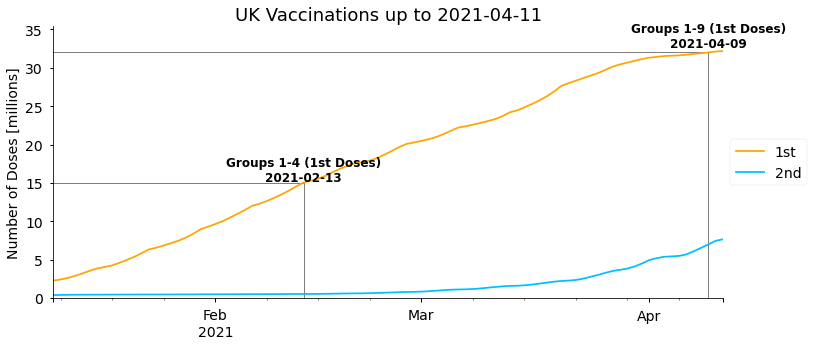

In [46]:
def plot_cumulative_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot cumulative first and second doses, and the dates when
    the vaccination of prioriy groups completed.
    Optionally distinguish actual data and forecasted data. Data
    after forecast_date will be displayed with a dashed line.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)  # remove border lines
    ax.spines["top"].set_visible(False)

    for col in ["cumFirst", "cumSecond"]:
        plot_column(
            df, col, ax,
            forecast_date=forecast_date,
        )
        annotate_group_completions(df, col, ax)

    ax.set_ylim(0, df["cumFirst"].max() * 1.1)
    ax.set_ylabel("Number of Doses [millions]")
    ax.set_xlabel("")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is not None:
        ax.set_title(title, fontsize=18)

        
plot_cumulative_doses(
    df, title=f"UK Vaccinations up to {df.index.date.max()}"
)

As stated in [Boris Johnson's address to the nation on 4th January 2021](https://www.gov.uk/government/speeches/prime-ministers-address-to-the-nation-4-january-2021), the first target the government set was to offer the first dose of a vaccine to everyone in the top four priority groups by mid-February. As we can see above this target was met on 13th February. The [next target set by the government](https://www.gov.uk/government/speeches/prime-ministers-statement-on-coronavirus-covid-19-10-february-2021) was then to offer a first dose to the first nine priority groups (the over 50s) with a first dose by the end of April. This was somewhat pessimistic given the vaccination rates at the time, and was ultimately completed a couple of weeks earlier on 9th April. Overall, the start of the UK vaccination programme has been very successful and amongst the fastest in the world.

It's also interesting to look at the daily number of new doses each day, and this is particularly relevant for forecasting future doses. We can create a similar function to do this, but as there's quite a large variation in the day to day totals (more on this below) we'll show the actual values as markers only and include lines for the weekly rolling averrages instead. We'll also display the combined total of 1st and 2nd doses (`newTot`) administered on each day, as this gives the best representation of the overall vaccine supply and capacity to administer vaccines.

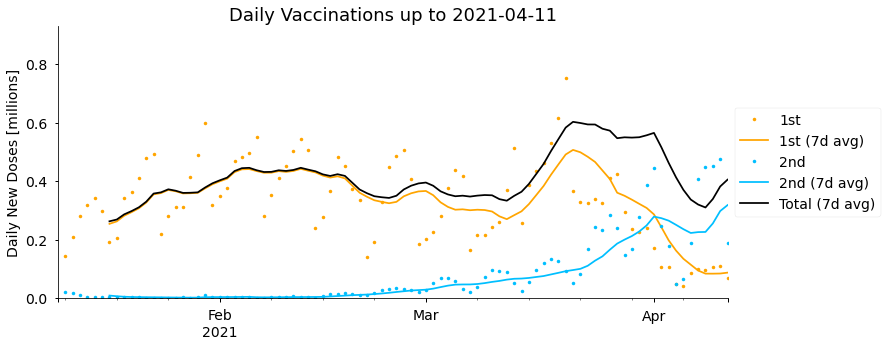

In [54]:
def plot_daily_doses(
    df, forecast_date=None,
    show_daily=True, show_rolling=True,
    figsize=figsize, title=None
):
    """
    Plot daily first doses, second doses, the sum of 1st
    and 2nd doses, and their weekly rolling averages.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    for col in ["newFirst", "newSecond", "newTot"]:
        if show_daily and col != "newTot":   # display daily data           
            plot_column(df, col, ax, marker=".", linestyle="None")

        if show_rolling:  # display 7 day averages
            plot_column(
                df, col, ax,
                forecast_date=forecast_date,
                rolling=True
            )

    ax.set_ylim(0, df["newTot"].max() * 1.1)
    ax.set_xlabel("")
    ax.set_ylabel("Daily New Doses [millions]")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is not None:
        ax.set_title(title, fontsize=18)

        
plot_daily_doses(
    df, title=f"Daily Vaccinations up to {df.index.date.max()}"
)

Between January and until early February the vaccine doses administered per day steadily increased from around 0.25 million to 0.45 million on average. After that date rates plateaued and temporarily fell, mostly due to challenges and [fluctuations in securing vaccine supplies](https://news.sky.com/story/covid-19-daily-drop-off-in-vaccinations-is-down-to-supply-fluctuations-but-will-pick-up-says-prof-jonathan-van-tam-12227465). Late March saw the highest rates, peaking at 0.6 million doses per day in the week starting 14th March, though this has since fallen again, particularly over the Easter weekend (2nd-5th April). Supply difficulties are currently [expected to continue in coming months](https://www.theguardian.com/politics/2021/apr/06/england-covid-vaccine-programme-could-slow-sharply-sage-warns). As well as fluctuations in the total we can see that the number of second doses administered has been steadily increasing, and overtook the rate of new first doses in early April. More on this later.

If you look closely at the actual daily numbers of 1st and 2nd doses (the markers rather than the rolling average lines), it seems like they vary up and down with a period of 7 days. We can make this clearer by plotting the number of doses delivered on each weekday. The day of the week for all the dates in our data can be determined using the pandas function `day_name`. Then we make use of the `boxplot` function in the `seaborn` plotting library to show the distribution in doses delivered on each weekday:

Text(0, 0.5, 'Daily Doses (1st + 2nd) [millions]')

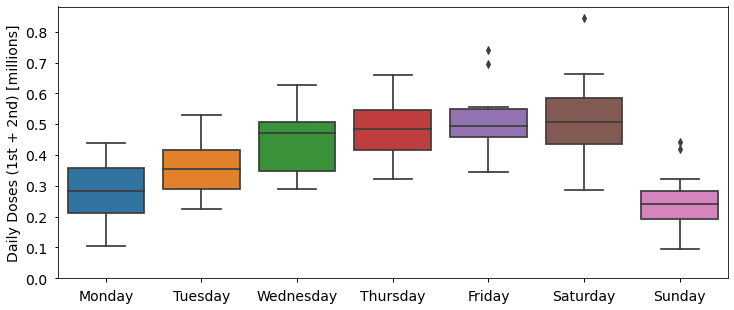

In [56]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=figsize)
sns.boxplot(
    x="weekday", y="newTot", data=df,
    order=[
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday",
        "Sunday"
    ]
)
plt.xlabel("")
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Daily Doses (1st + 2nd) [millions]")

In [57]:
df.groupby("weekday")["newTot"].mean()

weekday
Friday       0.506597
Monday       0.285143
Saturday     0.510266
Sunday       0.253384
Thursday     0.485818
Tuesday      0.367052
Wednesday    0.450878
Name: newTot, dtype: float64

More doses are administered Wednesday to Saturday than Sunday to Tuesday, with on average half as many (0.25 million) delivered on Sunday than on Friday (0.50 million). Although I could not find an official explanation for this, one factor is likely related to the capacity and opening hours of vaccination centres and GP surgeries, which are more likely to be closed on Sundays for example. Other statistics have similar trends, such as [fewer Covid-19 deaths being recorded at weekends due to reporting delays](https://www.bbc.co.uk/news/health-52167016).

## When are 2nd Doses Being Given?

A high-profile decision announced by the UK Joint Committee on Vaccination and Immunisation (JCVI) [on the 30th December 2020](https://www.gov.uk/government/publications/priority-groups-for-coronavirus-covid-19-vaccination-advice-from-the-jcvi-30-december-2020/joint-committee-on-vaccination-and-immunisation-advice-on-priority-groups-for-covid-19-vaccination-30-december-2020), was to delay second doses by as long as possible up to 12 weeks instead of the originally recommended 3-4 weeks. The decision was taken to be able to protect as many people as possible with a single dose of the vaccine within the first few months of the year, but [was fairly controversial at the time](https://www.bmj.com/content/372/bmj.n18) due to clinical trials using shorter gaps between doses.

The delay between first and second doses will be an important component in our forecasts, so let's calculate when second doses are actually being given in practice (more precisely than "up to 12 weeks"). We can estimate this by determining the number of days until the total number of second doses (`cumSecond`) matches the total number of first doses (`cumFirst`) on a given date. The for loop below calculates the delay for all dates in the past, and then prints the most recent delay:

In [22]:
for date_1st, row in df.iterrows():
    if row["cumFirst"] > df["cumSecond"].max():
        # reached the people who haven't been given the 2nd dose yet
        second_dose_days = delay
        print(
            "1st doses from", (date_1st - timedelta(days=1)).date(),
            "were completed", delay, "days later, on", date_2nd.date()
        )
        break

    # find the earliest date where 2nd doses matched/exceded 1st
    # doses on this date
    date_2nd = df[df["cumSecond"] >= row["cumFirst"]].index.min()
    
    # calculate and save how many days it was until 2nd doses were given
    delay = (date_2nd - date_1st).days
    df.loc[date_2nd, "delaySecond"] = delay


1st doses from 2021-01-27 were completed 74 days later, on 2021-04-11


Currently, second doses are lagging first doses by 74 days, or around ten and a half weeks. In the history of the data so far, the delay has varied between 71 and 75 days:

In [76]:
df["delaySecond"].min(), df["delaySecond"].max()

(71.0, 75.0)

With the gap increasing from 72 to 75 days over the Easter weekend (2nd-5th April) where fewer doses (of any type) were administered than normal:

Text(0, 0.5, '2nd Dose Delay [days]')

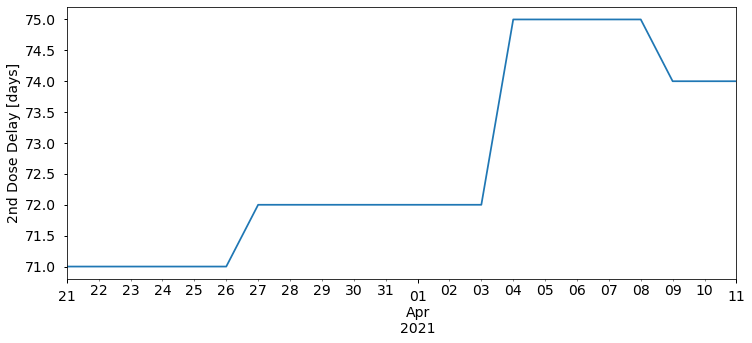

In [91]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df.loc[
    df.index >= datetime(2021, 3, 21),
    "delaySecond"
].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("2nd Dose Delay [days]")

The second dose delay values we calculate here are averages for the whole country. In reality, the delay for each individal will vary depending on the availability of appointments and vaccination strategy in their area. 

## Forecasting Future Vaccinations

In [25]:
def forecast_vaccines(
    df,
    second_dose_days,
    forecast_fn,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1)
):
    """
    Forecast future vaccine doses.

    df: DataFrame of actual vaccine data.
    second_dose_days: Days after 1st dose that 2nd doses will be given.
    forecast_fn: Function to calculate number of doses administered each
    day. Takes 2 arguments - df and a date.
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    """
    # extend our time series index to the future
    first_data = df.index.min()
    last_data = df.index.max()
    future_dates = pd.date_range(last_data, end_date, closed="right")
    df = df.append(pd.DataFrame(index=future_dates))
    df.sort_index(inplace=True)

    for d in future_dates:
        if d - timedelta(days=second_dose_days) < first_data:
            # no 1st dose data second_dose_days ago, assume no 2nd doses required
            pending_2nd_doses = 0
        else:
            # no. second doses needed today is difference between total
            # 2nd doses so far and 1st doses second_dose_days ago (who
            # now require 2nd dose)
            dose2_req = df.loc[
                d - timedelta(days=second_dose_days), "cumFirst"
            ]
            dose2_sofar =  df.loc[
                d - timedelta(days=1), "cumSecond"
            ]
            pending_2nd_doses = max([0, dose2_req - dose2_sofar])

        # use input forecasting function to determine number of doses available today
        total_doses_today = forecast_fn(df, d)
        # but don't vaccinate more than the total population (with 2 doses)
        if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
            total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]
        df.loc[d, "newTot"] = total_doses_today

        # prioritise 2nd doses over 1st doses - give all 2nd doses required (or as
        # many as possible if the number required is more than the total doses available)
        dose2_today = min(pending_2nd_doses, total_doses_today)
        df.loc[d, "newSecond"] = dose2_today
        df.loc[d, "cumSecond"] = df.loc[d - timedelta(days=1), "cumSecond"] + df.loc[d, "newSecond"]

        # remaining vaccines given as new 1st doses
        dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
        dose1_today = min(total_doses_today - dose2_today, dose1_remaining)
        df.loc[d, "newFirst"] = dose1_today
        df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + df.loc[d, "newFirst"]

        df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]
        
    return df


In [26]:
def forecast_lookback(
    df,
    second_dose_days,
    days_lookback=7,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1),
):
    """
    Forecast vaccine data assuming the number of vaccines given
    today is the same as 'days_lookback' days ago.
    """
    def lookback(df, date, days=days_lookback):
        """
        Return total number of doses given a number of days before
        the input date.
        """
        if date - timedelta(days=days) < df.index.min():
            return df.iloc[0]["newTot"]
        else:
            return df.loc[date - timedelta(days=days), "newTot"]

    df_forecast = forecast_vaccines(
        df,
        second_dose_days,
        forecast_fn=lookback,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


In [27]:
df_forecast = forecast_lookback(df, second_dose_days)

Text(0, 0.5, 'Total Doses [millions]')

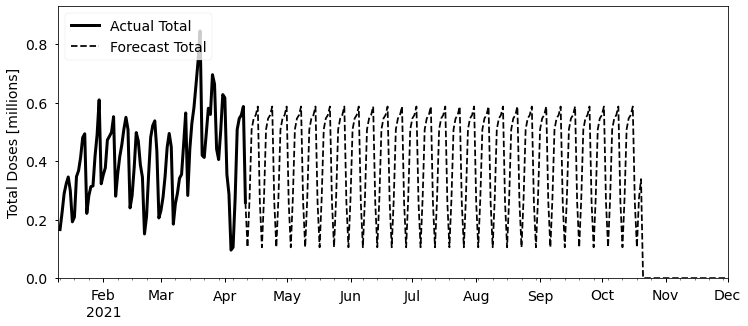

In [28]:
plt.figure(figsize=figsize)

total = df_forecast["newTot"]
last_data = df.index.max()
total[total.index <= last_data].plot(color="k", label="Actual Total", linewidth=3)
total[total.index >= last_data].plot(color="k", linestyle="--", label="Forecast Total")

plt.legend(loc="upper left")
plt.ylim([0, 1.1 * total.max()])
plt.ylabel("Total Doses [millions]")

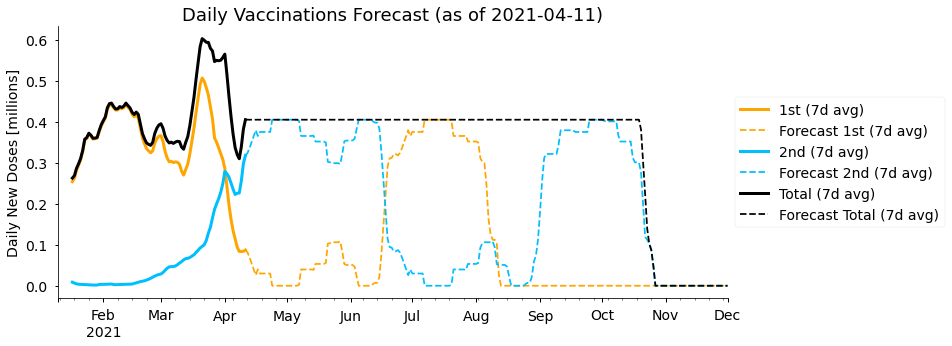

In [29]:
plot_daily_doses(
    df_forecast, forecast_date=last_data,
    show_daily=False,
    title=f"Daily Vaccinations Forecast (as of {df.index.date.max()})"
)

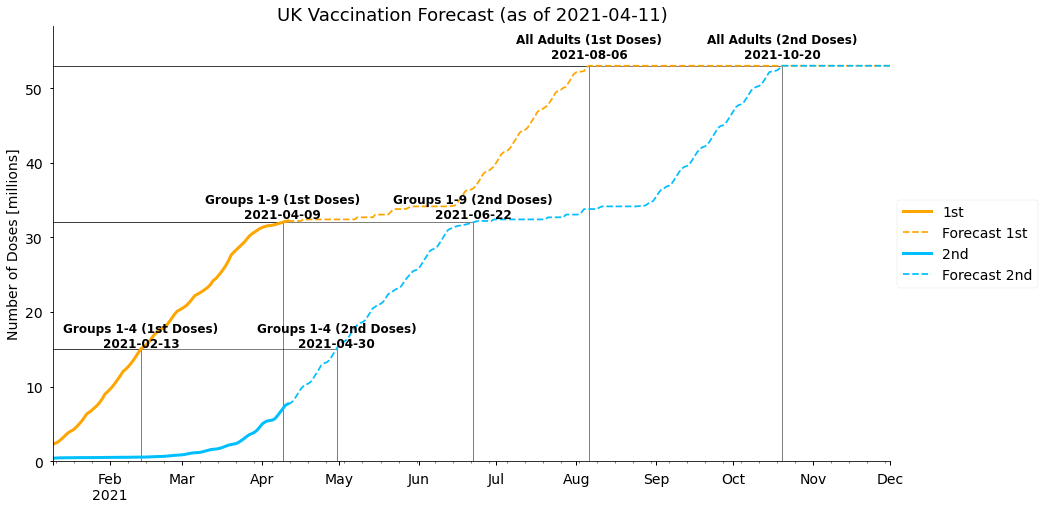

In [30]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8),
    title=f"UK Vaccination Forecast (as of {df.index.date.max()})"
)

## Uncertainty in Our Forecast

In [31]:
weekly_avg = df["newTot"].resample("W", label="left").mean()
# label="left" uses week start dates to label our averages, rather
# than week end dates (which is the default)

Text(0, 0.5, 'Week Starting')

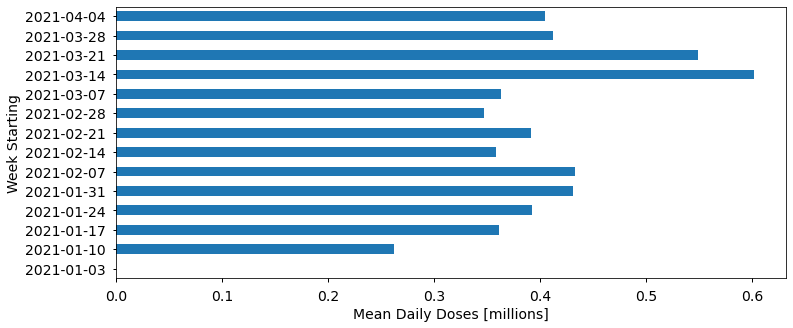

In [32]:
# only keep the date (not time) to tidy up axis labels
weekly_avg.index = weekly_avg.index.date

plt.figure(figsize=figsize)
weekly_avg.plot.barh()
plt.xlabel("Mean Daily Doses [millions]")
plt.ylabel("Week Starting")

In [33]:
weekly_avg.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9])

0.10    0.349226
0.25    0.361321
0.50    0.392361
0.75    0.430859
0.90    0.526194
Name: newTot, dtype: float64

In [34]:
def forecast_const(
    df,
    second_dose_days,
    daily_doses,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1)
):
    """
    Forecast vaccines assumming 'daily_doses' doses are given per day.
    """
    def const_doses(df, date):
        return daily_doses
    
    df_forecast = forecast_vaccines(
        df,
        second_dose_days,
        forecast_fn=const_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


In [35]:
quantiles = [0.1, 0.25, 0.75, 0.9]
forecast_q = {}
daily_doses_q = {}

for q in quantiles:
    daily_doses_q[q] = weekly_avg.quantile(q=q)
    forecast_q[q] = forecast_const(
        df,
        second_dose_days,
        daily_doses_q[q],
        uk_pop=priority_totals["All Adults"], 
    )


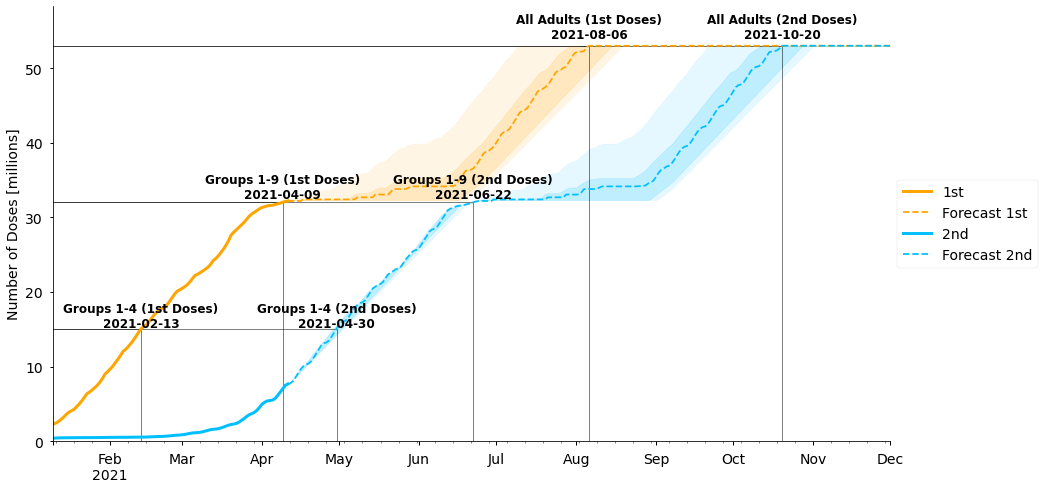

In [36]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8), 
)

q_fill = [
    # start quantile, end quantile, fill opacity (alpha)
    (0.1, 0.25, 0.1),
    (0.25, 0.75, 0.25),
    (0.75, 0.9, 0.1)
]
columns = [
    # column name, column colour
    ("cumFirst", "orange"),
    ("cumSecond", "deepskyblue")
]
for q_start, q_end, alpha in q_fill:
    for col, clr in columns:
        plt.fill_between(
            forecast_q[q_start].index,
            forecast_q[q_start][col],
            forecast_q[q_end][col],
            color=clr,
            alpha=alpha,
        )


## Government Targets and SAGE Vaccine Rollout Estimates

The government has the target of all UK adults being offered the vaccine by the end of July (https://www.bbc.co.uk/news/uk-56141867). This is currently in line with our optimistic forecast above, in which 0.43 million doses are given per day (on average).

Alternatively, the latest modelling from the Scientific Advisory Group for Emergencies (SAGE) (https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/975909/S1182_SPI-M-O_Summary_of_modelling_of_easing_roadmap_step_2_restrictions.pdf) uses the following two scenarios:
- **Fast scenario:** 0.39m doses per day in England until week commencing 26th July and 0.29m per day thereafter
- **Slow scenario:** 0.36m doses per week in England until week commencing 26th July and 0.29m per day thereafter


Note that these numbers are for England only, if we scale these up for the whole UK (56 million population England, 67 million population UK) we get:
- **Fast scenario:** 0.46m doses per day until week commencing 26th July and 0.34m per day thereafter
- **Slow scenario:** 0.43m doses per week until week commencing 26th July and 0.34m per day thereafter

SAGE also uses a 11-week (77 day) period between doses, several days longer than the 72 days we derived from the data.

In [37]:
def forecast_sage(
    df,
    second_dose_days,
    scenario="fast",
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1)
):
    """
    Forecast vaccines for the SAGE 'fast' and 'slow' scenarios.
    """
    if not (scenario == "fast" or scenario == "slow"):
        raise ValueError("scenario must be 'fast' or 'slow'")
    
    def sage_doses(df, date, scenario=scenario):
        if date > datetime(2021, 8, 1):
            return 0.34
        else:
            if scenario == "fast":
                return 0.46
            else:
                return 0.43

    df_forecast = forecast_vaccines(
        df,
        second_dose_days,
        forecast_fn=sage_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


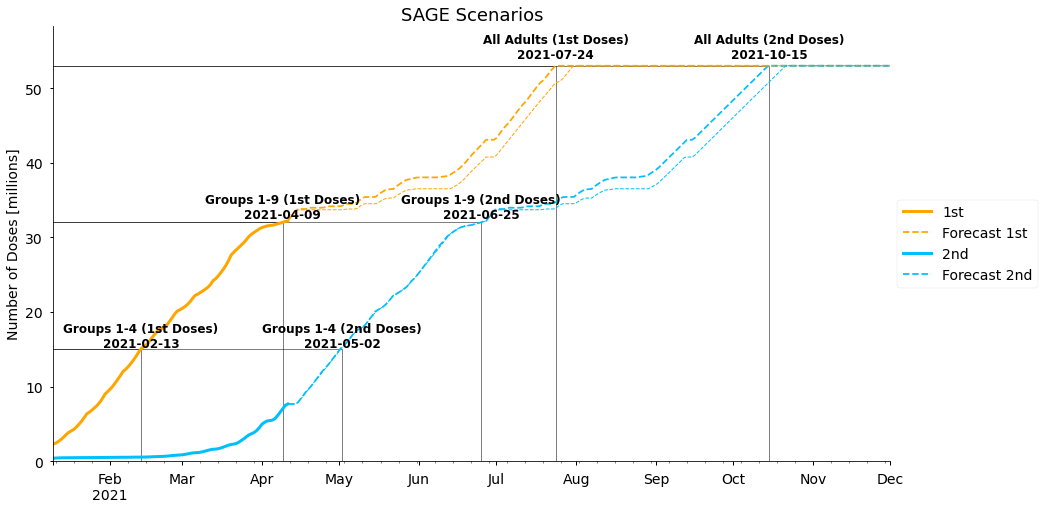

In [38]:
sage_2nd_delay = 77 # 11 weeks until 2nd dose
df_sage_fast = forecast_sage(
    df,
    sage_2nd_delay,  
    scenario="fast",
)
df_sage_slow = forecast_sage(
    df,
    sage_2nd_delay,  # 11 weeks until 2nd dose
    scenario="slow",
)

plot_cumulative_doses(
    df_sage_fast, forecast_date=last_data, figsize=(15, 8),
    title=f"SAGE Scenarios"
)

plt.plot(
    df_sage_slow["cumFirst"],
    color="orange", linestyle="--", linewidth=1
)
plt.plot(
    df_sage_slow["cumSecond"],
    color="deepskyblue", linestyle="--", linewidth=1
)


## Summary

Limitations:
- new vaccines (can't be used for 2nd doses initially)
- single dose vaccines

# BACKUP

## Stability of Forecasts


In [39]:
def run_forecasts(
    df,
    run_start,
    days_lookback=7,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2022, 3, 1)
):
    """
    Calculate the completion date of the UK vaccination programme
    with different forecast start dates. A forecast is run as if
    it was every day starting from the date run_start, up to the
    date of the latest available data.
    """
    forecast_start_dates = pd.date_range(    
        start=run_start, end=df.index.max()
    )
    # fill missing second dose delay values with nearest available value
    df["delaySecond"] = df["delaySecond"].bfill()

    completion_dates = pd.Series(index=forecast_start_dates, dtype=float)
    for forecast_start in forecast_start_dates:
        second_delay = df.loc[forecast_start - timedelta(days=1), "delaySecond"]
        df_forecast = forecast_lookback(
            df[df.index <= forecast_start],
            second_delay,
            days_lookback=days_lookback,
            uk_pop=uk_pop, 
            end_date=end_date
        )
        if df_forecast["cumSecond"].max() >= (uk_pop - 1e-7):
            finish_date = df_forecast[df_forecast["cumSecond"] >= (uk_pop - 1e-7)].iloc[0].name
            completion_dates.loc[forecast_start] = finish_date
        else:
            print(forecast_start.date(), ": Population not vaccinated by ", end_date.date())
            completion_dates.loc[forecast_start] = end_date
    
    return completion_dates

In [40]:
completion_dates = run_forecasts(df, datetime(2021, 2, 1))

Text(0.5, 0, 'Forecast Date')

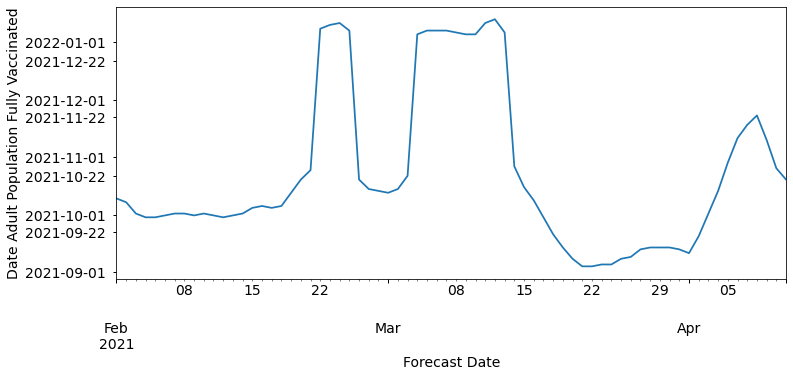

In [41]:
plt.figure(figsize=figsize)
completion_dates.plot()
plt.ylabel("Date Adult Population Fully Vaccinated")
plt.xlabel("Forecast Date")

Effect of Easter Bank Holiday

Stabilised mid-September?

There are several forecasts between late February and early March where the vaccine programme is not completed until January 2022, 2-3 months later than most forecasts at that time that have end dates in October. This looks a bit strange (why such big jumps?), but if we plot one of the forecasts with a late completion date we can see what's happening:

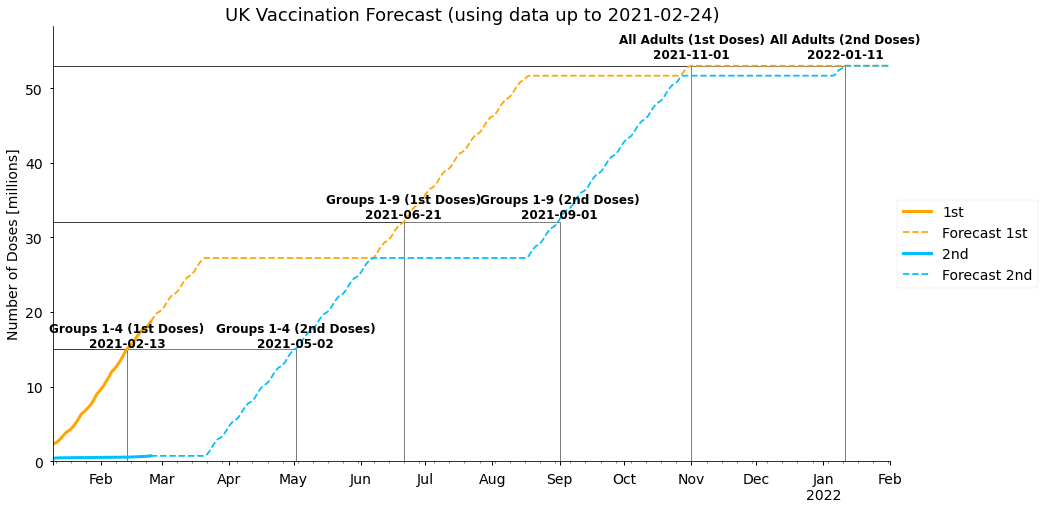

In [42]:
df_feb24 = forecast_lookback(
    df[df.index <= datetime(2021, 2, 24)],
    df.loc[datetime(2021, 2, 24), "delaySecond"],
    end_date=datetime(2022, 2, 1),
)
plot_cumulative_doses(
    df_feb24,
    forecast_date=datetime(2021, 2, 24),
    figsize=(15, 8), 
    title=f"UK Vaccination Forecast (using data up to {datetime(2021, 2, 24).date()})"
)

In the plot above, we see that in this forecast almost all adults are fully vaccinated by 20th August. However, before the remaining first doses can be given, a new batch of people requiring their second dose appear and must be given priority (without spare capacity for new first doses). 73 days later, on 1st November, the last few adults can start to be given their first dose. You'll notice that this 73 day delay in giving the last first doses is closely linked to the 72 day gap we assumed earlier between giving first doses and second doses. We can think of vaccines being given in alternating 72 day cycles of 1st doses and 2nd doses (at least in our simple forecast), and in the example above we have had to go through one additional cycle to complete the vaccination programme (compared to most forecasts which have completion datea in autumn 2021).

BUT
- assuming whole pop gets vaccinated etc.
- delay 2nd doses few days more in this case?